In [1]:
import pandas as pd 
from statsforecast import StatsForecast 
from statsforecast.models import (
    AutoETS,
    AutoTheta,
    CrostonOptimized,
    HoltWinters,
    WindowAverage,
    Naive,
    SeasonalNaive
)
import tsforge as tsf 
import numpy as np
from pathlib import Path
import os 
import matplotlib.pyplot as plt
import sys

MODEL_ZOO = [
    Naive(),
    CrostonOptimized(),
    WindowAverage(window_size=4, alias="MA4"), # often a strong baseline in retail forecasting 
    SeasonalNaive(season_length=52, alias="SN52"), #predict last years value 
    HoltWinters(season_length=52, alias="HW52"), #holtwinters is a special, simplified case of ETS 
    AutoTheta(
        season_length=52,
        decomposition_type="multiplicative",
    ), # automatic selection of the best Theta model/method, use multiplicative seasonlity 
    
    AutoETS(
        season_length=52,
        model="ZZZ", 
        damped=True,  # dampen the trend 
        phi=0.98,
    ), # AutoETS (Error,Trend,Seasonal) is a generalized State-Space Exponential Smoothing that automatically selects the best model
]

* simple intuition on single model class... 

In [2]:
# lets demonstrate how StatsForecast works

rand_ser = np.random.poisson(lam=4,size=200) # generate random numpy array... 

ets = MODEL_ZOO[-1] # pull out single model object 

# single models can only fit,predict,forecast on single series
ets.fit(rand_ser)

ets.predict(h=5) # here we fit and predict... 

fitted_model = ets.__dict__

In [3]:
fitted_model.get("model_") # a full summary of fitted model...

{'loglik': -668.0270775495127,
 'aic': 1348.0541550990254,
 'bic': 1367.8440592983136,
 'aicc': 1348.489388259647,
 'mse': 3.982673824565923,
 'amse': 3.981723541457361,
 'fit': results(x=array([1.00000000e-04, 1.00000000e-04, 9.80000000e-01, 3.85333835e+00,
        6.46303095e-03]), fn=1336.0541550990254, nit=345, simplex=array([[1.00000000e-04, 1.00009283e-04, 9.80000000e-01, 3.85722051e+00,
         6.38572942e-03],
        [1.00000000e-04, 1.00000000e-04, 9.80000000e-01, 3.85333835e+00,
         6.46303095e-03],
        [1.00000000e-04, 1.00000000e-04, 9.80000000e-01, 3.85218099e+00,
         6.41910851e-03],
        [1.00000000e-04, 1.00000000e-04, 9.80000000e-01, 3.84961681e+00,
         6.58276198e-03],
        [1.00000000e-04, 1.00000000e-04, 9.80000000e-01, 3.85254045e+00,
         6.49369762e-03],
        [1.00000000e-04, 1.00023207e-04, 9.80000000e-01, 3.85036676e+00,
         6.48350357e-03]])),
 'residuals': array([ 1.14032788e+00,  3.13389500e+00,  1.27082021e-01,  1.2068

In [ ]:
fitted_model.get("model_").get("method") 
# final ETS was with additive errors, additive-damped trend and N for NO Seasonality

'ETS(A,Ad,N)'

In [7]:
# Set working directory to project root
ROOT_DIR = Path("../..").resolve()
os.chdir(ROOT_DIR)
sys.path.insert(0, str(ROOT_DIR))

from utils import load_m5
import tsforge as tsf

import warnings

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-whitegrid")

DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

OUTPUT_DIR = DATA_DIR / "output"
OUTPUT_DIR.mkdir(exist_ok=True)

data = tsf.load_m5(data_dir=DATA_DIR, create_unique_id=True, verbose=False)


In [30]:
df = (
    data
    .groupby(["unique_id"])
    .resample("W-SAT", on="ds")
    .agg(y=("y", "sum"))
).reset_index()


In [33]:
# prepare statsforecast class

stat_fcst = StatsForecast(
    models=MODEL_ZOO,
    freq="W-SUN",  # set frequency to weekly
    n_jobs=-1,  # use all cpu cores
    fallback_model=Naive(),  # if we have any models that fail, fall back to naive
)


In [36]:
 # fit entire model zoo in parallel! 
stat_fcst.fit(
    df = df,
    id_col='unique_id',
    time_col='ds',
    target_col='y'
)

# predict future timesteps with all models for all series! 
preds = stat_fcst.predict(h=13)

/Users/jackrodenberg/Desktop/real-world-forecasting-foundations/.venv/lib/python3.12/site-packages/statsforecast/ets.py:653: RuntimeWarning: divide by zero encountered in scalar divide
  sigma2 = np.sum(e**2) / (ny - np_ - 1)
/Users/jackrodenberg/Desktop/real-world-forecasting-foundations/.venv/lib/python3.12/site-packages/statsforecast/ets.py:653: RuntimeWarning: divide by zero encountered in scalar divide
  sigma2 = np.sum(e**2) / (ny - np_ - 1)
/Users/jackrodenberg/Desktop/real-world-forecasting-foundations/.venv/lib/python3.12/site-packages/statsforecast/ets.py:653: RuntimeWarning: divide by zero encountered in scalar divide
  sigma2 = np.sum(e**2) / (ny - np_ - 1)
/Users/jackrodenberg/Desktop/real-world-forecasting-foundations/.venv/lib/python3.12/site-packages/statsforecast/ets.py:653: RuntimeWarning: divide by zero encountered in scalar divide
  sigma2 = np.sum(e**2) / (ny - np_ - 1)
/Users/jackrodenberg/Desktop/real-world-forecasting-foundations/.venv/lib/python3.12/site-packag

In [ ]:
fitted_models = stat_fcst.fitted_ # returns a numpy array of mxn fitted models 

fitted_models[:,5][0].model_ # fitted model attributes just as before but now for all timeseries 

{'mse': 657.8930658382649,
 'amse': array([13.01339745, 13.75221135, 14.8678093 ]),
 'fit': results(x=array([8.33058358, 0.24429054, 7.77987209]), fn=657.8930658382649, nit=156, simplex=array([[8.47863288, 0.24425567, 7.09527103],
        [8.4476337 , 0.24397611, 7.05837263],
        [8.47385914, 0.24432244, 6.89016711],
        [8.33058358, 0.24429054, 7.77987209]])),
 'residuals': array([-1.10898610e+01, -2.37415500e+00, -3.78761354e+00, -1.85577753e+00,
         4.60412922e+00,  4.48594188e+00, -1.60337341e+00, -4.20512660e+00,
        -3.17129610e+00, -6.39002061e+00, -1.82244118e+00,  1.62932181e+00,
        -2.76214823e+00, -4.08082369e+00,  1.29226408e+01, -2.22768022e+00,
        -1.67692116e+00,  6.73929267e+00, -5.90049490e+00, -3.45250197e+00,
         2.39746945e+00,  1.81834821e+00, -4.61929919e+00, -2.48429025e+00,
         1.29156213e-01,  1.10416243e+00, -4.15901614e+00, -3.13644999e+00,
        -5.36368708e+00, -4.04683122e+00, -3.05167079e+00, -2.29961863e+00,
       

In [58]:
fitted_model_df = pd.DataFrame(
    data = fitted_models,
    index=stat_fcst.uids,
).reset_index().melt(
    id_vars='unique_id',
    value_name='model',
).drop("variable",axis=1)

In [120]:
subset = fitted_model_df.loc[fitted_model_df['unique_id'] == "FOODS_1_001_CA_1"].reset_index(drop=True)
ts = data.loc[data['unique_id'] == "FOODS_1_001_CA_1",'y'].to_numpy()

* examining attributes of fitted models 
* accessing fitted parameters and predictions
* understanding model interfaces
* comparing model performance and diagnostics
(here we skip MA, SN52, and Croston as they don't offer much..)



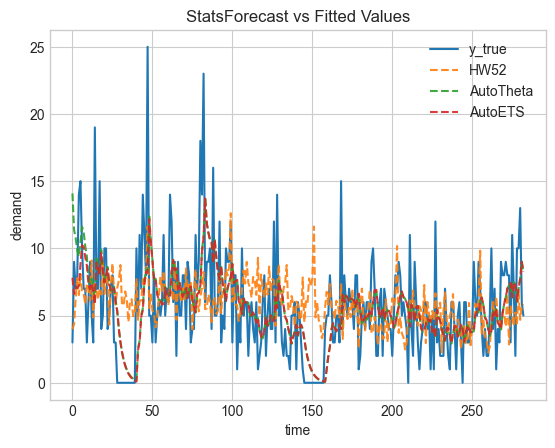

In [121]:
# plot original series
plt.plot(ts,label='y_true')

for i in range(4,7):
    sub_df = subset.loc[i]
    plt.plot(
    sub_df["model"].model_["fitted"], 
    label=sub_df["model"].alias,
    alpha=.9,
    linestyle='--')

plt.legend()
plt.title("StatsForecast vs Fitted Values")
plt.ylabel("demand")
plt.xlabel("time")
plt.show()

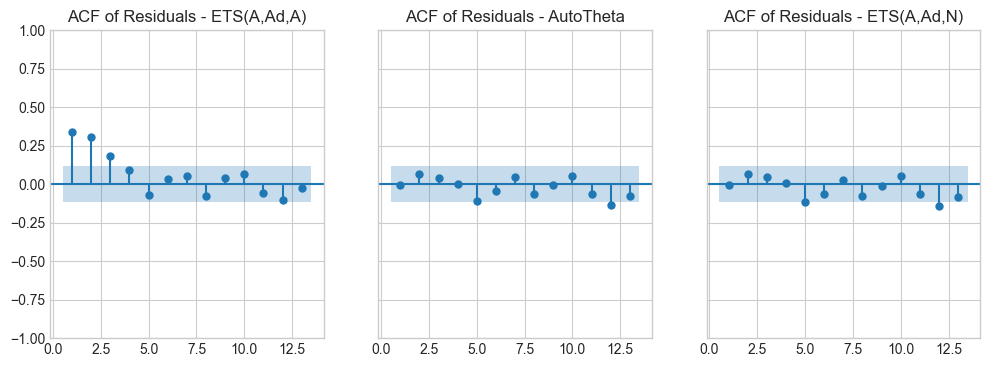

In [ ]:
# plotting ACF in the residuals
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1,3,sharey=True,figsize=(12,4))
for i in range(4, 7):
    sub_df = subset.loc[i]
    if sub_df['model'].model_.get('method'):
        name = sub_df['model'].model_.get('method')
    else:
        name = sub_df["model"].alias
    plot_pacf(
        sub_df["model"].model_["residuals"], 
        lags=13,
       # adjusted=True,
       title=f"ACF of Residuals - {name}", 
        zero=False,
        ax=ax[i-4]
    )

fig.suptitle(f"{subset.loc[i,'unique_id']}")
# here we see AutoETS doesn't have seasonal component added... 
# 
# the holt-winters method does which causes it to have Autocorrelation in the residuals


In [ ]:
# now lets just use the .forecast method to fit/predict as fast as possible 

forecast = stat_fcst.forecast(
    h=13,
    df=data,
    id_col="unique_id",
    target_col="y",
    time_col="ds",
)

/Users/jackrodenberg/Desktop/real-world-forecasting-foundations/.venv/lib/python3.12/site-packages/statsforecast/ets.py:653: RuntimeWarning: divide by zero encountered in scalar divide
  sigma2 = np.sum(e**2) / (ny - np_ - 1)
/Users/jackrodenberg/Desktop/real-world-forecasting-foundations/.venv/lib/python3.12/site-packages/statsforecast/ets.py:653: RuntimeWarning: divide by zero encountered in scalar divide
  sigma2 = np.sum(e**2) / (ny - np_ - 1)
/Users/jackrodenberg/Desktop/real-world-forecasting-foundations/.venv/lib/python3.12/site-packages/statsforecast/ets.py:653: RuntimeWarning: divide by zero encountered in scalar divide
  sigma2 = np.sum(e**2) / (ny - np_ - 1)
/Users/jackrodenberg/Desktop/real-world-forecasting-foundations/.venv/lib/python3.12/site-packages/statsforecast/ets.py:653: RuntimeWarning: divide by zero encountered in scalar divide
  sigma2 = np.sum(e**2) / (ny - np_ - 1)
/Users/jackrodenberg/Desktop/real-world-forecasting-foundations/.venv/lib/python3.12/site-packag

In [ ]:
tsf.plot_timeseries(
    df = data,
    id_col='unique_id',
    date_col='ds',
    value_col='y',
    group_col='unique_id',
    freq="W-SAT",
    max_ids=4,
    forecast=forecast,
    forecast_value_col="AutoETS"

)